## Why Object Segmentation Matters in Autonomous Driving

Object segmentation is a **core perception component** in autonomous driving, enabling fine-grained scene understanding beyond bounding-box detection.  
By providing **pixel-level (or point-level) object representations**, segmentation directly supports safety-critical decision making.

---

### Precise Scene Geometry
Segmentation allows autonomous systems to:
- Capture **exact object shapes and boundaries**
- Handle **occlusion and overlapping objects**
- Improve spatial reasoning compared to coarse bounding boxes

This is crucial in dense urban traffic and complex road layouts.

---

### Safety-Critical Decisions
Accurate segmentation benefits downstream modules such as:
- **Motion planning** (free space vs. occupied space)
- **Collision avoidance**
- **Behavior and trajectory prediction**

Small perception errors can lead to large planning failures.

---

### Robustness in Real-World Scenarios
Segmentation improves robustness under:
- Heavy occlusion
- Crowded multi-agent scenes
- Visually complex environments

By modeling objects at a fine granularity, the system can reason more reliably.

---

### Foundation for Advanced Perception
High-quality segmentation enables:
- Panoptic perception (semantic + instance)
- Multi-modal fusion (camera + LiDAR)
- 3D occupancy and long-term scene understanding

As autonomy scales, segmentation becomes **foundational, not optional**.

---

**Takeaway:**  
Object segmentation bridges perception and decision-making, forming a critical backbone of safe and scalable autonomous driving systems.


## Scope of This Tutorial: Object Segmentation with COCO 2014

This notebook provides a **hands-on, code-driven tutorial** on object segmentation using the **COCO 2014 dataset**.  
The focus is on understanding the **end-to-end segmentation pipeline**, rather than achieving state-of-the-art performance.

---

### What We Will Do

In this tutorial, we will:

- Load COCO images and annotations with `pycocotools`
- Generate **binary object segmentation masks** from instance annotations
- Build a custom **PyTorch Dataset and DataLoader**
- Train a **U-Net–style segmentation model**
- Implement **training and validation loops**
- Visualize **images, ground-truth masks, and predictions**
- Save and reload the **best model** based on validation loss

The emphasis is on clarity and reproducibility of the full workflow.

---

### Why COCO 2014?

COCO 2014 is an ideal dataset for learning segmentation because it offers:
- Diverse real-world scenes
- High-quality instance-level annotations
- Complex object layouts and occlusions

Although COCO is a 2D vision dataset, the concepts learned here transfer naturally to:
- Autonomous driving perception
- LiDAR-based 3D / 4D segmentation
- Panoptic and occupancy prediction tasks

---

### Learning Objective

By the end of this notebook, you should be able to:
- Understand the structure of segmentation datasets
- Implement a complete segmentation pipeline in PyTorch
- Debug common segmentation issues (data, masks, loss, visualization)
- Build intuition applicable to **autonomous driving perception systems**

This tutorial serves as a foundation for more advanced topics such as **panoptic segmentation and 4D scene understanding**.


📦 Dataset Preparation

Before running this notebook, the COCO 2014 dataset must be downloaded and placed in the appropriate directory structure, so that images and annotation files can be correctly located by the data loader.

In [2]:
!pip install pycocotools
!pip install --upgrade scikit-image scipy
!pip install seaborn

In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

from random import shuffle
from PIL import Image

from pycocotools.coco import COCO

In [ ]:
dataDir='[DATASET_PATH]'
dataType='val2014'
annFile='{}annotations/instances_{}.json'.format(dataDir,dataType)
imageDir = '{}/{}/'.format(dataDir, dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.49s)
creating index...
index created!


In [5]:
# Load categories for the given ids
ids = 1
cats = coco.loadCats(ids=ids)
print(cats)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}]


In [6]:
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  80
[{'supercategory': 'person', 'id': 1, 'name': 'person'}]
[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]
[{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
[{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}]
[{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}]
[{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
[{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}]
[{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}]
[{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}]
[{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}]
[{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}]
[{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[{'supercategory': 'animal', 'id': 16, 'name': 'bird'}]
[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]
[{'supercategory': 'animal',

In [7]:
# Load images for the given ids
image_ids = coco.getImgIds()
image_id = image_ids[0]  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
print(image_info)

[{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}]


In [8]:
# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
print(annotations)

[{'segmentation': [[376.97, 176.91, 398.81, 176.91, 396.38, 147.78, 447.35, 146.17, 448.16, 172.05, 448.16, 178.53, 464.34, 186.62, 464.34, 192.28, 448.97, 195.51, 447.35, 235.96, 441.69, 258.62, 454.63, 268.32, 462.72, 276.41, 471.62, 290.98, 456.25, 298.26, 439.26, 292.59, 431.98, 308.77, 442.49, 313.63, 436.02, 316.86, 429.55, 322.53, 419.84, 354.89, 402.04, 359.74, 401.24, 312.82, 370.49, 303.92, 391.53, 299.87, 391.53, 280.46, 385.06, 278.84, 381.01, 278.84, 359.17, 269.13, 373.73, 261.85, 374.54, 256.19, 378.58, 231.11, 383.44, 205.22, 385.87, 192.28, 373.73, 184.19]], 'area': 12190.44565, 'iscrowd': 0, 'image_id': 391895, 'bbox': [359.17, 146.17, 112.45, 213.57], 'category_id': 4, 'id': 151091}, {'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361.0, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.85, 26.39, 383.54, 22.16, 

In [9]:
# Get category ids that satisfy the given filter conditions
filterClasses = ['laptop', 'tv', 'cell phone']
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

[72, 73, 77]


In [10]:
catID = 15
print(coco.loadCats(ids=catID))

# Get image ids that satisfy the given filter conditions
imgId = coco.getImgIds(catIds=[catID])[0]
print(imgId)

[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
262148


In [11]:
ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(ann_ids)

[247584, 576412, 642663, 1209372, 1251030, 1272930, 1277823, 1303789, 1307874, 1312222, 1312550, 1321181, 1324108, 1331011, 1332687, 1371763, 1372845, 1422576, 1837952, 1962686, 2007683, 2061640, 900100262148]


Annotations for Image ID 262148:
COCO_val2014_000000262148.jpg


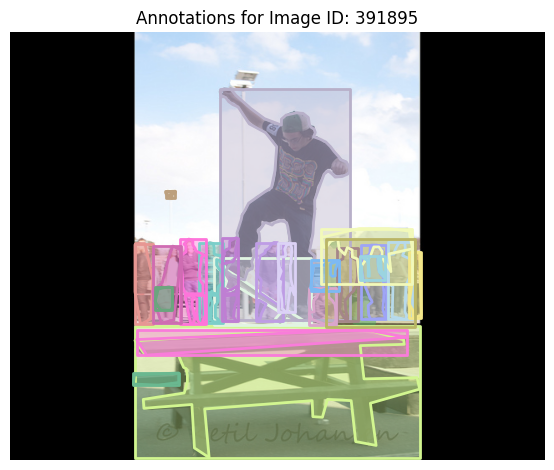

In [12]:
print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(image_id))
plt.tight_layout()
plt.show()

In [13]:
def main():

    # Category IDs.
    cat_ids = coco.getCatIds()
    print(f"Number of Unique Categories: {len(cat_ids)}")
    print("Category IDs:")
    print(cat_ids)  # The IDs are not necessarily consecutive.

    # All categories.
    cats = coco.loadCats(cat_ids)
    cat_names = [cat["name"] for cat in cats]
    print("Categories Names:")
    print(cat_names)

    # Category ID -> Category Name.
    query_id = cat_ids[0]
    query_annotation = coco.loadCats([query_id])[0]
    query_name = query_annotation["name"]
    query_supercategory = query_annotation["supercategory"]
    print("Category ID -> Category Name:")
    print(
        f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}"
    )

    # Category Name -> Category ID.
    query_name = cat_names[2]
    query_id = coco.getCatIds(catNms=[query_name])[0]
    print("Category Name -> ID:")
    print(f"Category Name: {query_name}, Category ID: {query_id}")

    # Get the ID of all the images containing the object of the category.
    img_ids = coco.getImgIds(catIds=[query_id])
    print(f"Number of Images Containing {query_name}: {len(img_ids)}")

    # Pick one image.
    img_id = img_ids[2]
    img_info = coco.loadImgs([img_id])[0]
    img_file_name = img_info["file_name"]
    img_url = img_info["coco_url"]
    print(
        f"Image ID: {img_id}, File Name: {img_file_name}, Image URL: {img_url}"
    )

    # Get all the annotations for the specified image.
    ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    print(f"Annotations for Image ID {img_id}:")
    print(anns)

    # Use URL to load image.
    # im = Image.open(requests.get(img_url, stream=True).raw)
    # Load image from dataset
    im = plt.imread(imageDir+ coco.loadImgs(img_id)[0]['file_name'])
    # Save image and its labeled version.
    plt.axis("off")
    plt.imshow(np.asarray(im))
    plt.savefig(f"{img_id}.jpg", bbox_inches="tight", pad_inches=0)
    # Plot segmentation and bounding box.
    coco.showAnns(anns, draw_bbox=True)
    plt.savefig(f"{img_id}_annotated.jpg", bbox_inches="tight", pad_inches=0)
    plt.show()
    return


if __name__ == "__main__":

    main()

Number of Unique Categories: 80
Category IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
Categories Names:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted

In [14]:
# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get category names
category_names = [cat['name'].title() for cat in cats]

# Get category counts
category_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
category_counts = [len(img_ids) for img_ids in category_counts]


# Create a color palette for the plot
colors = sns.color_palette('viridis', len(category_names))

# Create a horizontal bar plot to visualize the category counts
plt.figure(figsize=(11, 15))
sns.barplot(x=category_counts, y=category_names, palette=colors)

# Add value labels to the bars
for i, count in enumerate(category_counts):
    plt.text(count + 20, i, str(count), va='center')
plt.xlabel('Count',fontsize=20)
plt.ylabel('Category',fontsize=20)
plt.title('Category Distribution in COCO Dataset',fontsize=25)
plt.tight_layout()
plt.savefig('coco-cats.png',dpi=300)
plt.show()

/tmp/ipykernel_448128/966428849.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts, y=category_names, palette=colors)


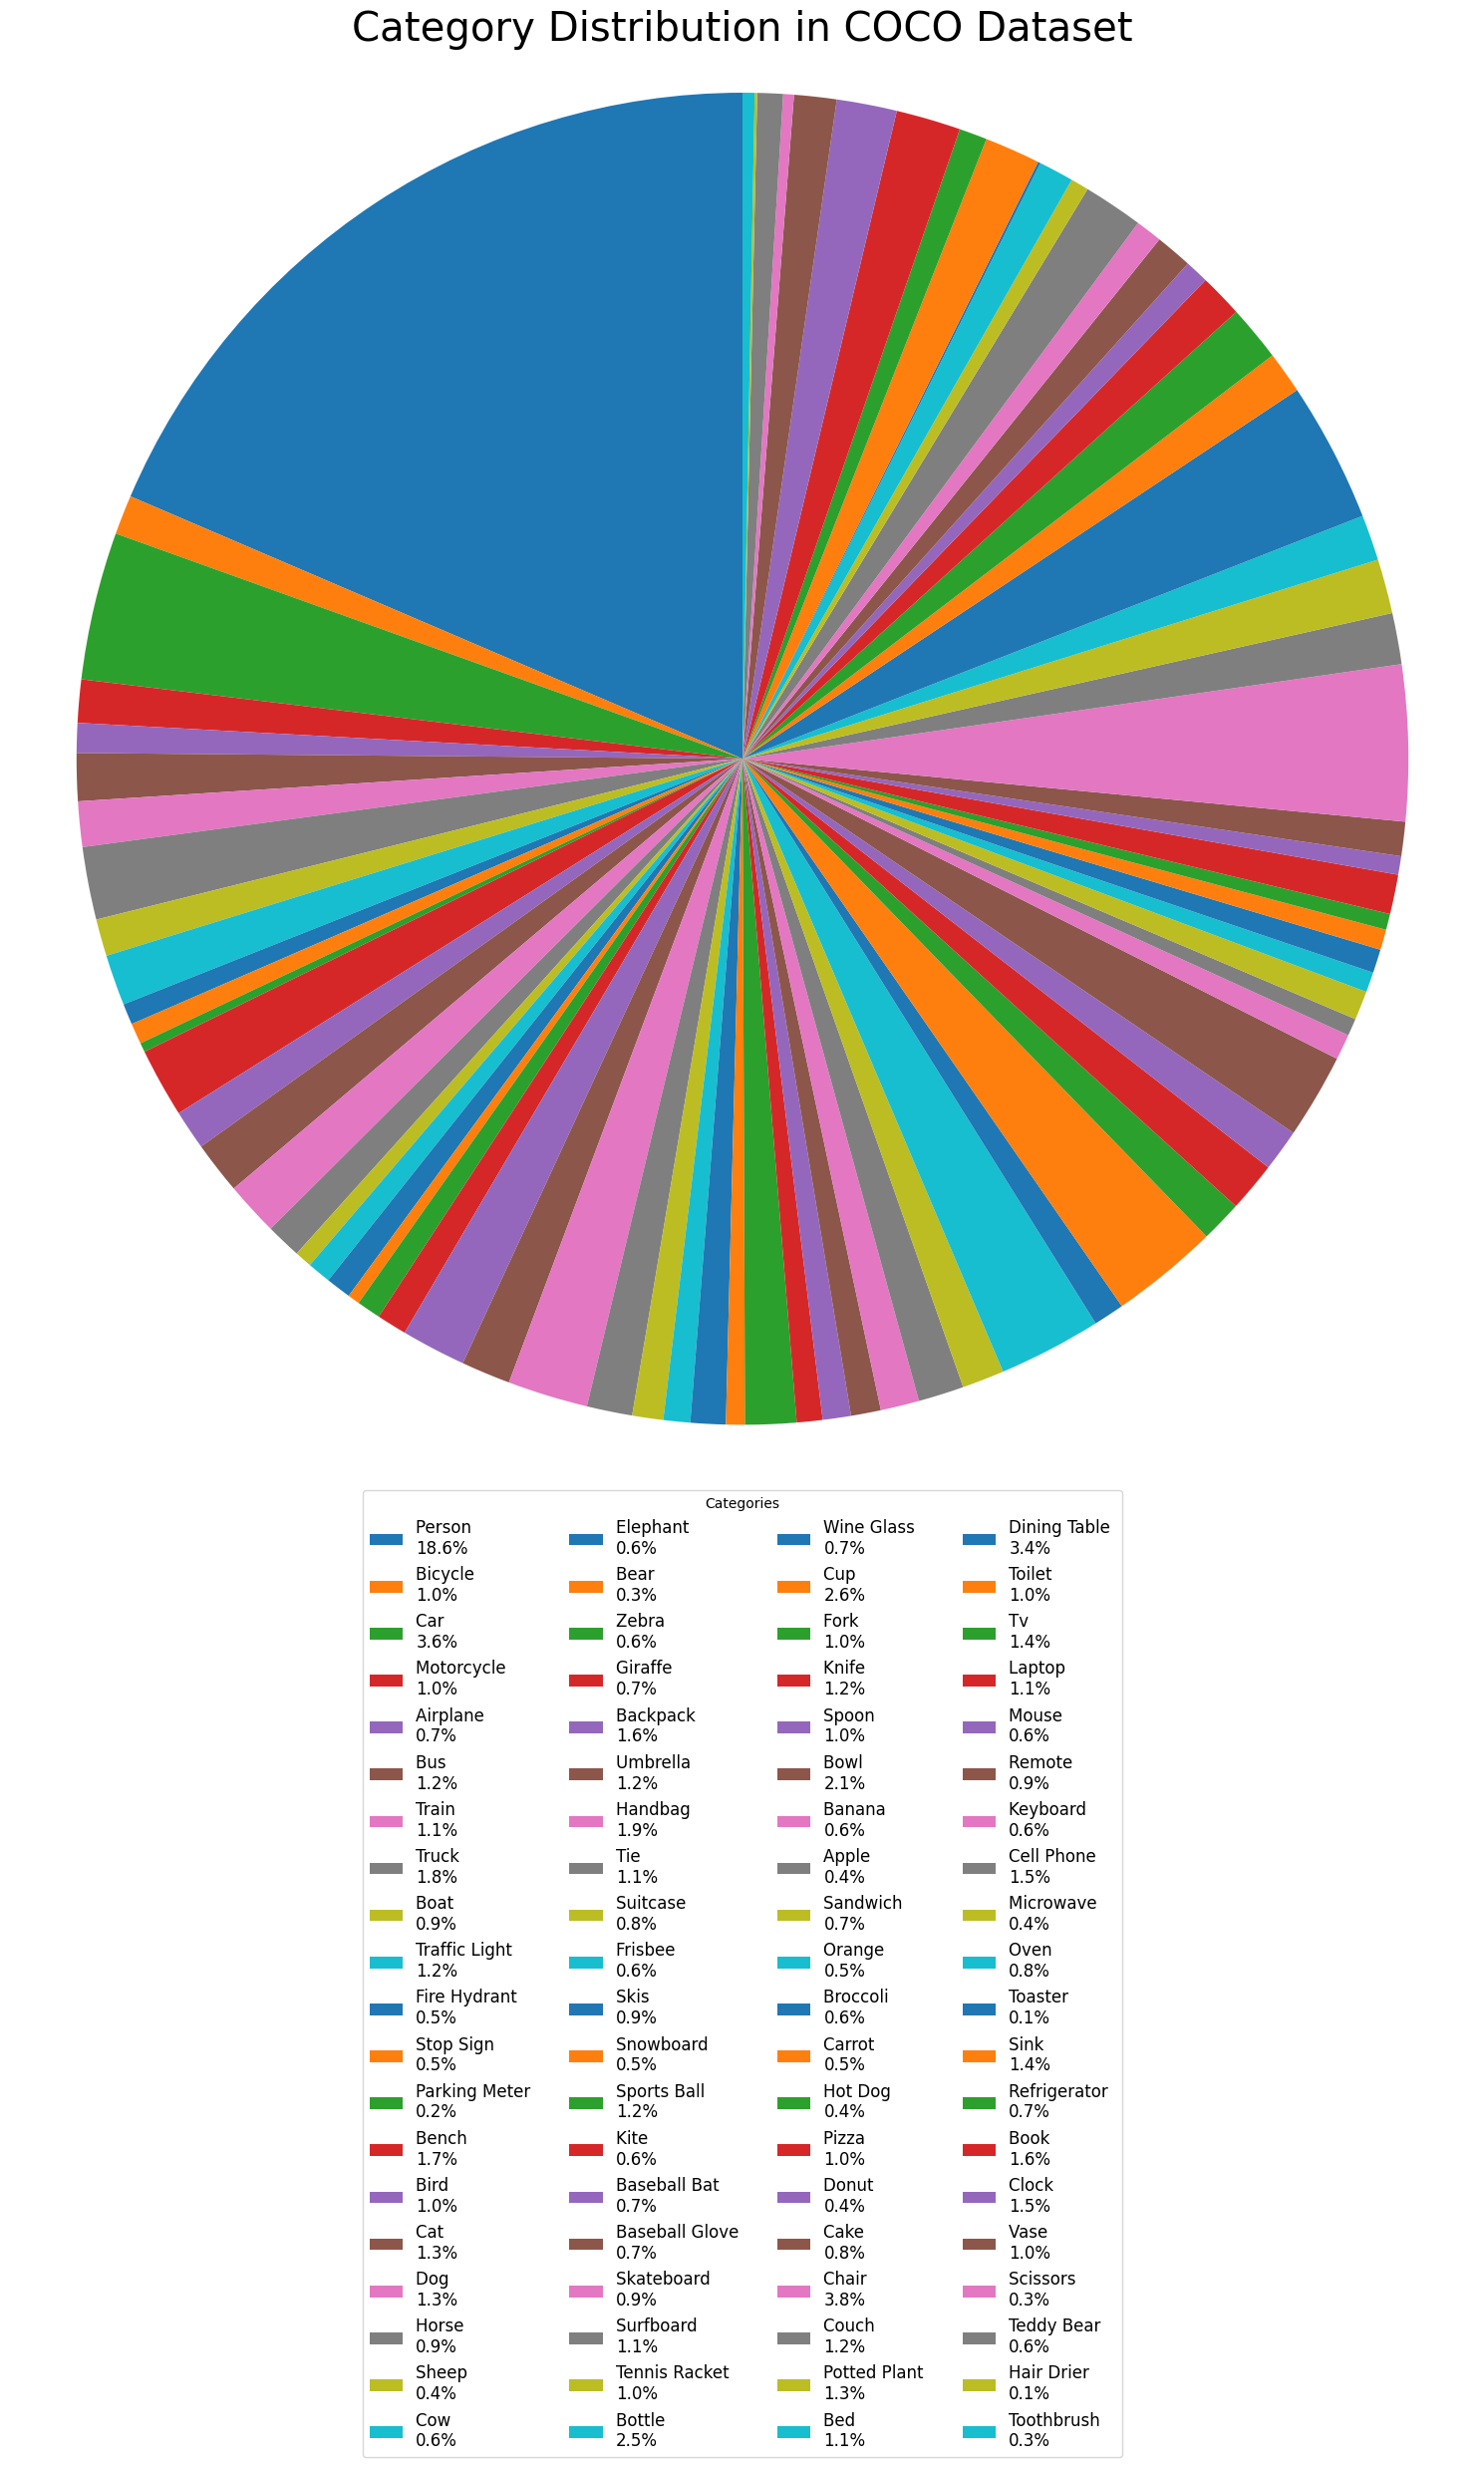

In [15]:
# Calculate percentage for each category
total_count = sum(category_counts)
category_percentages = [(count / total_count) * 100 for count in category_counts]


# Create a pie chart to visualize the category distribution
plt.figure(figsize=(15, 24.9))


# Customize labels properties
labels = [f"{name} " for name, percentage in zip(category_names, category_percentages)]
label_props = {"fontsize": 25, 
               "bbox": {"edgecolor": "white", 
                        "facecolor": "white", 
                        "alpha": 0.7, 
                        "pad": 0.5}
              }

# Add percentage information to labels, and set labeldistance to remove labels from the pie
wedges, _, autotexts = plt.pie(category_counts, 
                              autopct='', 
                              startangle=90, 
                              textprops=label_props, 
                              pctdistance=0.85)

# Create the legend with percentages
legend_labels = [f"{label}\n{category_percentages[i]:.1f}%" for i, label in enumerate(labels)]
plt.legend(wedges, legend_labels, title="Categories", loc="upper center", bbox_to_anchor=(0.5, -0.01), 
           ncol=4, fontsize=12)

plt.axis('equal')
plt.title('Category Distribution in COCO Dataset', fontsize=29)
plt.tight_layout()
plt.savefig('coco-dis.png', dpi=300)
plt.show()

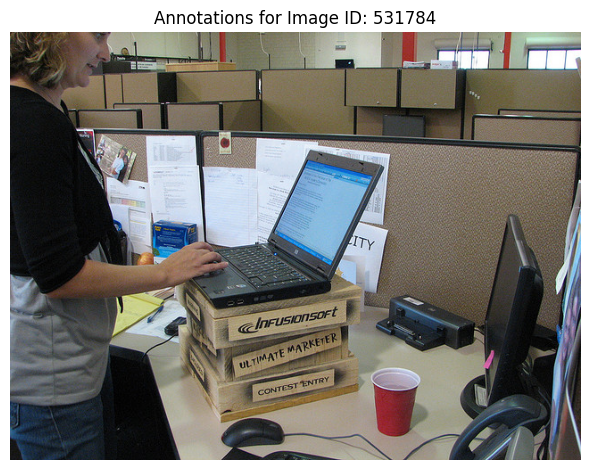

In [16]:
# Define the classes (out of the 80) which you want to see. Others will not be shown.
filterClasses = ['laptop', 'tv', 'cell phone']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)

# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)

# Load a random image from the filtered list
if len(imgIds) > 0:
    image_id = imgIds[np.random.randint(len(imgIds))]  # Select a random image ID
    image_info = coco.loadImgs(image_id)

    if image_info is not None and len(image_info) > 0:
        image_info = image_info[0]
        image_path = imageDir + image_info['file_name']

        # Load the annotations for the image
        annotation_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotation_ids)

        # Get category names and assign colors for annotations
        category_names = [coco.loadCats(ann['category_id'])[0]['name'].capitalize() for ann in annotations]
        category_colors = list(matplotlib.colors.TABLEAU_COLORS.values())

        # Load the image and plot it
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Annotations for Image ID: {}'.format(image_id))
        plt.tight_layout()
        plt.savefig('Img.png',dpi=350)
        plt.show()
        
        plt.imshow(image)
        plt.axis('off')

        # Display bounding boxes and segmented colors for each annotation
        for ann, color in zip(annotations, category_colors):
            bbox = ann['bbox']
            segmentation = ann['segmentation']

            # Display bounding box
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,
                                     edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)

            # Display segmentation masks with assigned colors
            for seg in segmentation:
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                plt.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.6)

        # Create a legend with category names and colors
        legend_patches = [patches.Patch(color=color, label=name) for color, name in zip(category_colors, category_names)]
        plt.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.2), fontsize='small')

        # Show the image with legend
        plt.title('Annotations for Image ID: {}'.format(image_id))
        plt.tight_layout()
        plt.savefig('annImg.png',dpi=350)
        plt.show()
    else:
        print("No image information found for the selected image ID.")
else:
    print("No images found for the desired classes.")

In [17]:
# Extracting Mask Information
# Load annotations for a specific image ID
# Load images for the given ids
image_ids = coco.getImgIds()
image_id = image_ids[0] 
annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

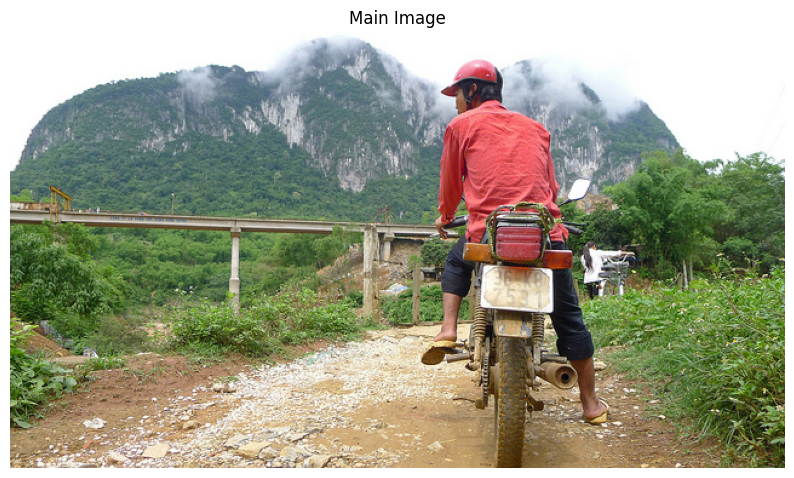

In [18]:
# Retrieve image file path
image_info = coco.loadImgs(image_id)[0]
image_dir = os.path.join(dataDir, 'val2014')
image_path = os.path.join(image_dir, image_info['file_name'])

# Load the main image
main_image = plt.imread(image_path)

# Create a new figure for displaying the main image
plt.figure(figsize=(10, 10))
plt.imshow(main_image)
plt.axis('off')
plt.title('Main Image')

# Save the figures
plt.savefig('main_image.png', dpi=300)

# Show the plots
plt.show()

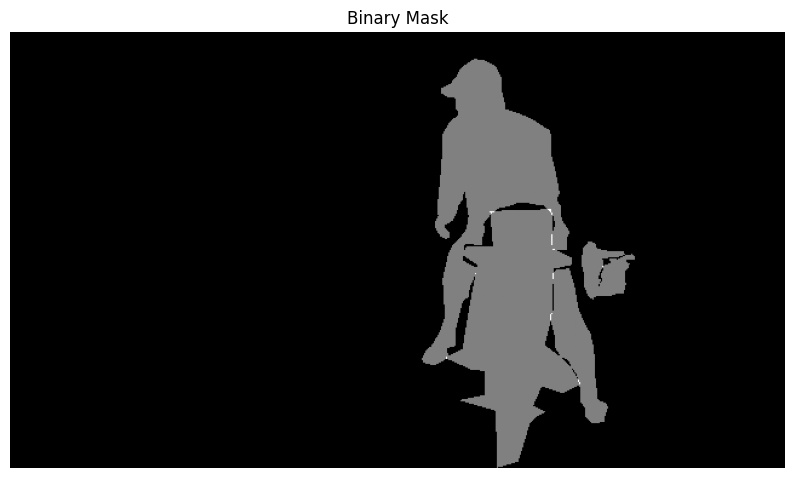

In [19]:
# Retrieve image dimensions
image_info = coco.loadImgs(image_id)[0]
height, width = image_info['height'], image_info['width']

# Create an empty binary mask with the same dimensions as the image
binary_mask = np.zeros((height, width), dtype=np.uint8)

# Iterate through the annotations and draw the binary masks
for annotation in annotations:
    segmentation = annotation['segmentation']
    mask = coco.annToMask(annotation)

    # Add the mask to the binary mask
    binary_mask += mask

# Display the binary mask
plt.figure(figsize=(10,10))
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title('Binary Mask')
plt.savefig('binary_mask.png', dpi=300)
plt.show()

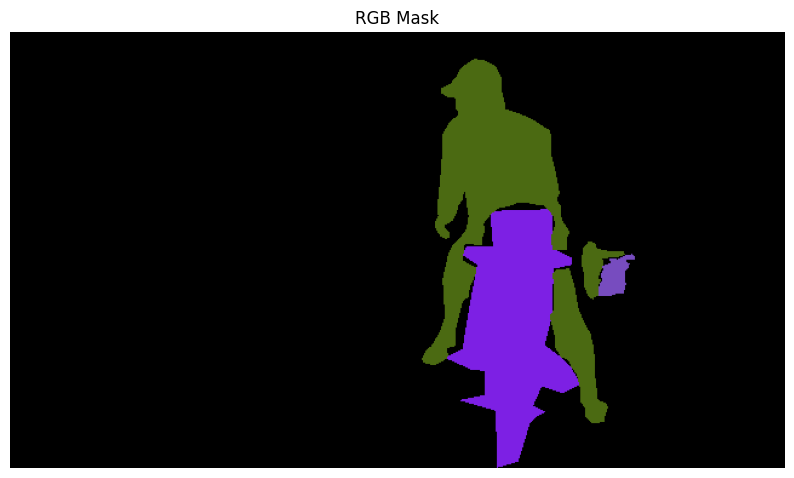

In [20]:
# Retrieve image dimensions
image_info = coco.loadImgs(image_id)[0]
height, width = image_info['height'], image_info['width']

# Create an empty RGB mask with the same dimensions as the image
rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Define a color map for different object classes
color_map = {cat['id']: (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
             for cat in coco.loadCats(catIDs)}

# Iterate through the annotations and assign unique colors to each class/object
for annotation in annotations:
    category_id = annotation['category_id']
    color = color_map[category_id]

    # Draw the mask on the RGB mask
    mask = coco.annToMask(annotation)
    rgb_mask[mask == 1] = color

# Display the RGB mask
plt.figure(figsize=(10,10))
plt.imshow(rgb_mask)
plt.axis('off')
plt.title('RGB Mask')
plt.savefig('rgb_mask.png', dpi=300)
plt.show()

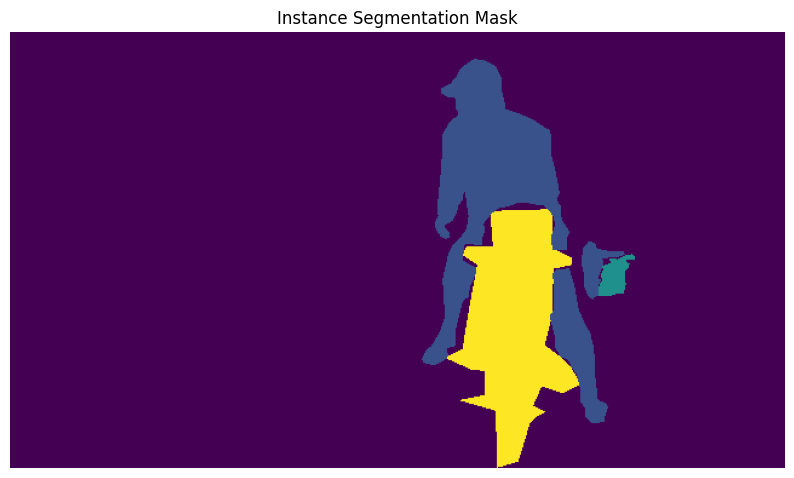

In [21]:
# Retrieve image dimensions
image_info = coco.loadImgs(image_id)[0]
height, width = image_info['height'], image_info['width']

# Create an empty mask with the same dimensions as the image
instance_mask = np.zeros((height, width), dtype=np.uint8)

# Iterate through the annotations and draw the instance segmentation masks
for annotation in annotations:
    segmentation = annotation['segmentation']
    mask = coco.annToMask(annotation)
    category_id = annotation['category_id']

    # Assign a unique value to each instance mask
    instance_mask[mask == 1] = category_id

# Display the instance segmentation mask
plt.figure(figsize=(10,10))
plt.imshow(instance_mask, cmap='viridis')
plt.axis('off')
plt.title('Instance Segmentation Mask')
plt.savefig('instance_mask.png', dpi=300)
plt.show()

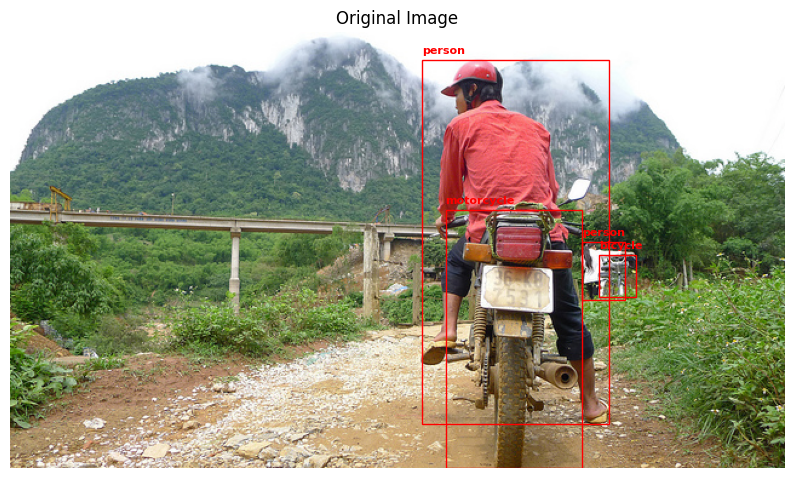

In [22]:
# Retrieve image dimensions
image_info = coco.loadImgs(image_id)[0]
height, width = image_info['height'], image_info['width']

# Create a new figure with the same dimensions as the image
fig, ax = plt.subplots(figsize=(10,10), dpi=100)

# Display the original image
ax.imshow(main_image)
ax.axis('off')
ax.set_title('Original Image')

# Draw bounding boxes on the original image
for annotation in annotations:
    bbox = annotation['bbox']
    category_id = annotation['category_id']
    category_name = coco.loadCats(category_id)[0]['name']

    # Convert COCO bounding box format (x, y, width, height) to matplotlib format (xmin, ymin, xmax, ymax)
    xmin, ymin, width, height = bbox
    xmax = xmin + width
    ymax = ymin + height

    # Draw the bounding box rectangle
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Add the category name as a label above the bounding box
    ax.text(xmin, ymin - 5, category_name, fontsize=8, color='red', weight='bold')

# Save the figure with adjusted dimensions
plt.savefig('bounding_boxes.png', bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_448128/4165453174.py:3: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


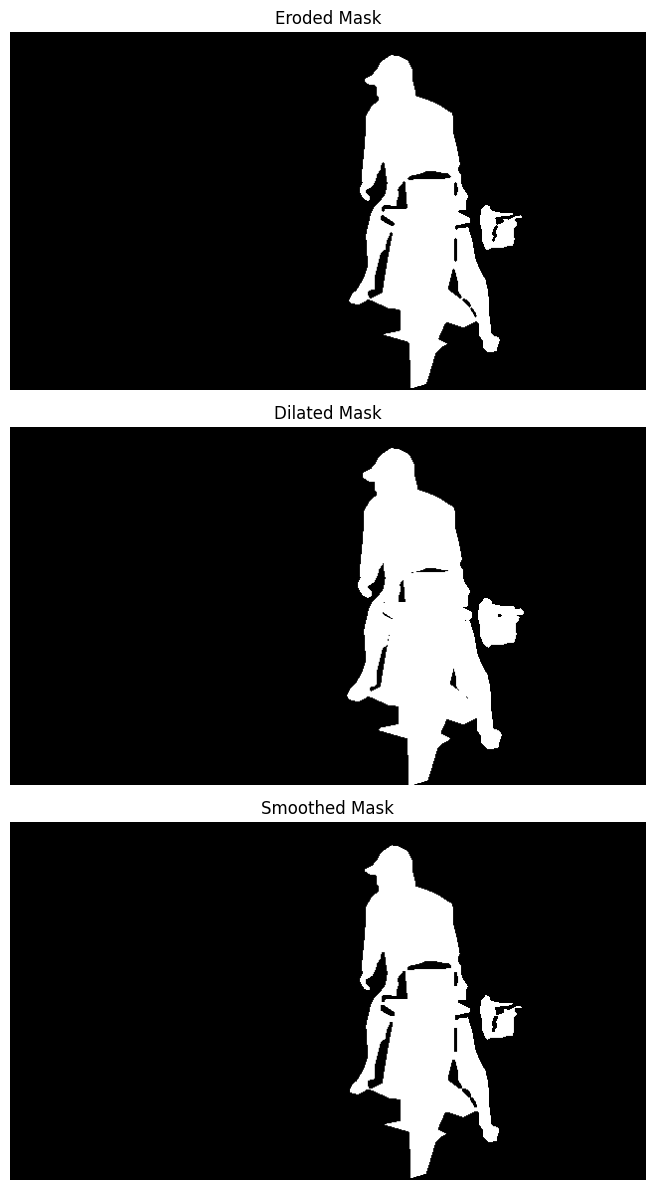

In [23]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage.filters import gaussian_filter

# Apply erosion to the binary mask
eroded_mask = binary_erosion(binary_mask)

# Apply dilation to the binary mask
dilated_mask = binary_dilation(binary_mask)

# Apply Gaussian blur to the binary mask
smoothed_mask = gaussian_filter(binary_mask, sigma=.2)

# Display the post-processed masks
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].imshow(eroded_mask, cmap='gray')
axes[0].set_title('Eroded Mask')
axes[0].axis('off')

axes[1].imshow(dilated_mask, cmap='gray')
axes[1].set_title('Dilated Mask')
axes[1].axis('off')

axes[2].imshow(smoothed_mask, cmap='gray')
axes[2].set_title('Smoothed Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('post_processed_masks.png', dpi=300)
plt.show()

In [24]:
import numpy as np

# Ground truth mask
gt_mask = binary_mask.astype(bool)  # Example ground truth mask

# Predicted mask
predicted_mask = smoothed_mask.astype(bool)  # Example predicted mask

# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask)
union = np.logical_or(gt_mask, predicted_mask)
iou = np.sum(intersection) / np.sum(union)

# Print the IoU score
print(f"Intersection over Union (IoU): {iou:.4f}")

Intersection over Union (IoU): 0.9161


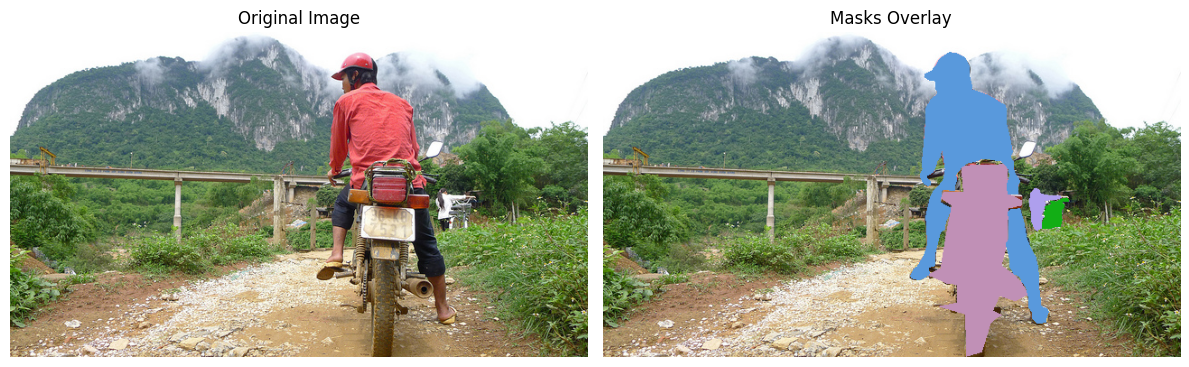

In [25]:
# Select an image ID for visualization
image_id = image_ids[0]

# Load the image
image_info = coco.loadImgs(image_id)[0]
image_path = os.path.join(imageDir, image_info['file_name'])
image = plt.imread(image_path)

# Get the ground truth annotations for the image
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)

# Create a blank image for overlaying the masks
overlay = image.copy()

# Iterate over the annotations and draw the masks on the overlay image
for annotation in annotations:
    # Get the segmentation mask
    mask = coco.annToMask(annotation)
    
    # Choose a random color for the mask
    color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
    
    # Apply the mask to the overlay image
    overlay[mask == 1] = color

# Create a figure and subplot for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

# Plot the image with overlay masks
ax2.imshow(overlay)
ax2.set_title('Masks Overlay')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the visualization as an image file
plt.savefig('mask_visualization.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
!pip uninstall -y tensorflow-io
!pip install tensorflow-io
!pip install tensorflow

In [ ]:
import os, random
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

ANNOTATION_FILE_TRAIN = '[DATASET_PATH]/annotations/instances_train2014.json'
ANNOTATION_FILE_VAL   = '[DATASET_PATH]/annotations/instances_val2014.json'

classes = ['person']

coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)

coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)

print("train imgs / cats:", len(imgIds_train), len(catIds_train))
print("val imgs / cats:", len(imgIds_val), len(catIds_val))

random.shuffle(imgIds_train)
random.shuffle(imgIds_val)

imgIds_train = imgIds_train[:6000]
imgIds_val   = imgIds_val[:600]
print("subset:", len(imgIds_train), len(imgIds_val))

def save_union_masks(coco, imgIds, catIds, out_dir, prefix):
    os.makedirs(out_dir, exist_ok=True)
    for ID in imgIds:
        file_path = os.path.join(out_dir, f"{prefix}_{ID:012d}.png")

        annIds = coco.getAnnIds(imgIds=[ID], catIds=catIds, iscrowd=0)
        anns = coco.loadAnns(annIds)
        if len(anns) == 0:
            # 혹시라도 empty면 0-mask 저장(이미지 크기 정보가 필요해서 skip 권장)
            continue

        mask = coco.annToMask(anns[0]).astype(np.uint8)
        for a in anns[1:]:
            mask |= coco.annToMask(a).astype(np.uint8)

        Image.fromarray(mask * 255).save(file_path)

# 저장 (시간 좀 걸릴 수 있음)
save_union_masks(coco_train, imgIds_train, catIds_train, "[DATASET_PATH]/mask_train_2014", "COCO_train2014")
save_union_masks(coco_val,   imgIds_val,   catIds_val,   "[DATASET_PATH]/mask_val_2014",   "COCO_val2014")


class CocoPersonSegFromMaskFiles(Dataset):
    def __init__(self, images_dir, masks_dir, imgIds, prefix, size=128):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.imgIds = imgIds
        self.prefix = prefix

        self.img_tf = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),  # [0,1], (C,H,W)
        ])
        self.mask_tf = transforms.Compose([
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),  # [0,1], (1,H,W)
        ])

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        ID = self.imgIds[idx]

        img_path  = os.path.join(self.images_dir, f"{self.prefix}_{ID:012d}.jpg")
        mask_path = os.path.join(self.masks_dir,  f"{self.prefix}_{ID:012d}.png")

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        image = self.img_tf(image)
        mask  = self.mask_tf(mask)
        mask  = (mask > 0.1).float()  # binary

        return image, mask

train_images_dir = "[DATASET_PATH]/train2014"
val_images_dir   = "[DATASET_PATH]/val2014"

train_ds = CocoPersonSegFromMaskFiles(
    images_dir=train_images_dir,
    masks_dir="[DATASET_PATH]/mask_train_2014",
    imgIds=imgIds_train,
    prefix="COCO_train2014",
    size=128
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

val_ds = CocoPersonSegFromMaskFiles(
    images_dir=val_images_dir,
    masks_dir="[DATASET_PATH]/mask_val_2014",
    imgIds=imgIds_val,
    prefix="COCO_val2014",
    size=128
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,      
    num_workers=2,
    pin_memory=True
)

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)   # (B,3,128,128), (B,1,128,128)
print(imgs.min().item(), imgs.max().item(), masks.unique())



loading annotations into memory...
Done (t=15.64s)
creating index...
index created!
loading annotations into memory...
Done (t=1.49s)
creating index...
index created!
train imgs / cats: 45174 1
val imgs / cats: 21634 1
subset: 6000 600
torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])
0.0 1.0 tensor([0., 1.])


In [31]:
import torch, sys
print("python:", sys.executable)
print("torch file:", torch.__file__)
print("torch version attr exists?:", hasattr(torch, "version"))
print("torch __version__:", getattr(torch, "__version__", None))


python: /home/kuaicv/anaconda3/envs/coco_test/bin/python
torch file: /home/kuaicv/anaconda3/envs/coco_test/lib/python3.10/site-packages/torch/__init__.py
torch version attr exists?: True
torch __version__: 2.5.1+cu121


In [ ]:
def validate_image_shapes(dataloader):
    """
    Print the shapes of preprocessed images generated by a PyTorch DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader)
    """
    for batch_idx, (images, masks) in enumerate(dataloader):
        # images: (B, C, H, W)
        for i in range(images.shape[0]):
            print(f"Batch {batch_idx}, image {i} shape: {images[i].shape}")

validate_image_shapes(train_loader)

In [ ]:
# Print the number of files in the train2014 directory containing original images
print(len(os.listdir("[DATASET_PATH]/train2014")))

# Print the number of files in the mask_train_2014 directory containing generated masks
print(len(os.listdir("[DATASET_PATH]/mask_train_2014")))

# Print the number of files in the val2014 directory containing original images
print(len(os.listdir("[DATASET_PATH]/val2014")))

# Print the number of files in the mask_val_2014 directory containing generated masks
print(len(os.listdir("[DATASET_PATH]/mask_val_2014")))

82783
6000
40504
600


Mask Image Shape: (461, 640)
Main Image Shape: (461, 640, 3)


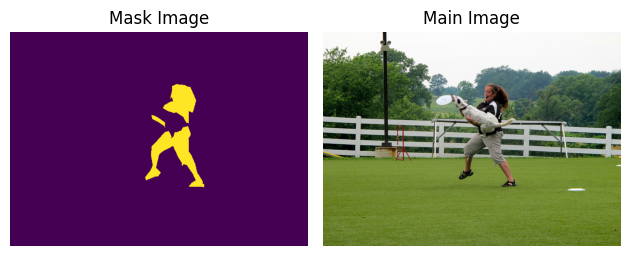

In [ ]:
images_path="[DATASET_PATH]/train2014"
masks_path="[DATASET_PATH]/mask_train_2014"
# Get the list of mask filenames
mask_filenames = [filename for filename in os.listdir(masks_path) if filename.endswith('.png')]

# Assuming the first image in the mask folder is the one to plot
first_mask_filename = mask_filenames[0]
image_filename = os.path.splitext(first_mask_filename)[0] + '.jpg'

# Load and plot the mask image
mask_image = Image.open(os.path.join(masks_path, first_mask_filename))
plt.subplot(1, 2, 1)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.axis('off')

# Load and plot the corresponding main image
main_image = Image.open(os.path.join(images_path, image_filename))
plt.subplot(1, 2, 2)
plt.imshow(main_image)
plt.title('Main Image')
plt.axis('off')

# Print the shapes of the images
print('Mask Image Shape:', np.array(mask_image).shape)
print('Main Image Shape:', np.array(main_image).shape)

plt.tight_layout()
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
device = torch.device("cuda:0")   
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        skip = x
        pooled = self.pool(x)
        return skip, pooled

class Bottleneck(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        # Keras: UpSampling2D -> Conv2D(kernel_size=(2,2), out_ch)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_conv = nn.Conv2d(in_ch, out_ch, kernel_size=2, padding=0, bias=False)
        self.up_bn   = nn.BatchNorm2d(out_ch)

        # after concat: (skip_ch + out_ch) -> out_ch
        self.conv1 = nn.Conv2d(out_ch + out_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.up(x)
        x = self.relu(self.up_bn(self.up_conv(x)))

        
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="nearest")

        x = torch.cat([skip, x], dim=1)  # channel concat

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class OutputBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv3x3 = nn.Conv2d(in_ch, 2, kernel_size=3, padding=1)
        self.conv1x1 = nn.Conv2d(2, 1, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv3x3(x))
        x = torch.sigmoid(self.conv1x1(x))
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        fs = [64, 128, 256, 512, 1024]

        self.d1 = DownBlock(in_channels, fs[0])
        self.d2 = DownBlock(fs[0], fs[1])
        self.d3 = DownBlock(fs[1], fs[2])
        self.d4 = DownBlock(fs[2], fs[3])

        self.b  = Bottleneck(fs[3], fs[4])

        self.u4 = UpBlock(fs[4], fs[3])
        self.u3 = UpBlock(fs[3], fs[2])
        self.u2 = UpBlock(fs[2], fs[1])
        self.u1 = UpBlock(fs[1], fs[0])

        self.out = OutputBlock(fs[0])

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        s1, p1 = self.d1(x)
        s2, p2 = self.d2(p1)
        s3, p3 = self.d3(p2)
        s4, p4 = self.d4(p3)

        b = self.b(p4)

        x = self.u4(b, s4)
        x = self.u3(x, s3)
        x = self.u2(x, s2)
        x = self.u1(x, s1)

        return self.out(x)


In [36]:
model = UNet(in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()   


In [37]:
x = torch.randn(8, 3, 128, 128).to(device)
y = model(x)
print(y.shape)  


torch.Size([8, 1, 128, 128])


In [38]:
import torch
from torchinfo import summary

model_cpu = UNet().to("cpu").eval()

summary(
    model_cpu,
    input_size=(1, 3, 128, 128),
    device="cpu",    
    depth=4,
    col_names=("input_size", "output_size", "num_params")
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet                                     [1, 3, 128, 128]          [1, 1, 128, 128]          --
├─DownBlock: 1-1                         [1, 3, 128, 128]          [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 3, 128, 128]          [1, 64, 128, 128]         1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         [1, 64, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         [1, 64, 128, 128]         36,864
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         [1, 64, 128, 128]         128
│    └─ReLU: 2-6                         [1, 64, 128, 128]         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 64, 128, 128]         [1, 64, 64, 64]           --
├─DownBlock: 1-2          

In [39]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    for images, masks in loader:
        images = images.to(device)            
        masks  = masks.to(device)             

        optimizer.zero_grad()

        outputs = model(images)               
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks  = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [40]:
import torch
import os

num_epochs = 20
best_val_loss = float("inf")

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss = validate_one_epoch(
        model, val_loader, criterion, device
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
            },
            os.path.join(save_dir, "best_model.pth")
        )
        print(f"🔥 Best model saved (val_loss = {val_loss:.4f})")


Epoch [1/20] Train Loss: 0.4046 | Val Loss: 0.3248
🔥 Best model saved (val_loss = 0.3248)
Epoch [2/20] Train Loss: 0.3127 | Val Loss: 0.3004
🔥 Best model saved (val_loss = 0.3004)
Epoch [3/20] Train Loss: 0.2913 | Val Loss: 0.3026
Epoch [4/20] Train Loss: 0.2766 | Val Loss: 0.2781
🔥 Best model saved (val_loss = 0.2781)
Epoch [5/20] Train Loss: 0.2679 | Val Loss: 0.2853
Epoch [6/20] Train Loss: 0.2552 | Val Loss: 0.2769
🔥 Best model saved (val_loss = 0.2769)
Epoch [7/20] Train Loss: 0.2428 | Val Loss: 0.2664
🔥 Best model saved (val_loss = 0.2664)
Epoch [8/20] Train Loss: 0.2270 | Val Loss: 0.2782
Epoch [9/20] Train Loss: 0.2170 | Val Loss: 0.2662
🔥 Best model saved (val_loss = 0.2662)
Epoch [10/20] Train Loss: 0.2053 | Val Loss: 0.3166
Epoch [11/20] Train Loss: 0.1935 | Val Loss: 0.2943
Epoch [12/20] Train Loss: 0.1812 | Val Loss: 0.2946
Epoch [13/20] Train Loss: 0.1766 | Val Loss: 0.2821
Epoch [14/20] Train Loss: 0.1709 | Val Loss: 0.2719
Epoch [15/20] Train Loss: 0.1600 | Val Loss: 0.

Visible GPU count: 1
Using GPU: NVIDIA GeForce RTX 3060
Loaded best model from epoch 9 (val_loss = 0.2662)


/tmp/ipykernel_448128/2113057334.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")  # 안전하게 cpu로 로드


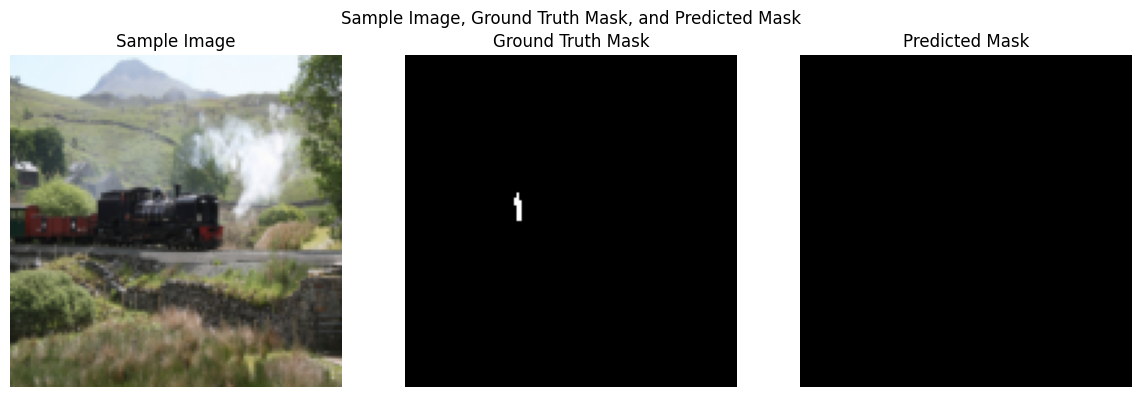

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 이제 CUDA_VISIBLE_DEVICES 덕분에 "보이는 GPU 0"이 RTX 3060임
assert torch.cuda.is_available(), "CUDA not available. Check driver / env."
print("Visible GPU count:", torch.cuda.device_count())
print("Using GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda:0")  
# ===============================
# 🔥 BEST MODEL LOAD
# ===============================
ckpt_path = "./checkpoints/best_model.pth"

checkpoint = torch.load(ckpt_path, map_location="cpu")  # 안전하게 cpu로 로드
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device).eval()

print(f"Loaded best model from epoch {checkpoint.get('epoch', 'N/A')} "
      f"(val_loss = {checkpoint.get('val_loss', float('nan')):.4f})")

# ===============================
# VALIDATION BATCH
# ===============================
images, masks = next(iter(val_loader))
images = images.to(device, non_blocking=True)
masks  = masks.to(device, non_blocking=True)

# ===============================
# PREDICTION
# ===============================
with torch.no_grad():
    logits = model(images)                  # (B,1,H,W) if 마지막에 sigmoid 없을 때
    probs  = torch.sigmoid(logits)          # sigmoid가 이미 모델에 있으면 이 줄 제거
    preds  = (probs > 0.5).float()

# ===============================
# CPU + NUMPY
# ===============================
images_np = images.detach().cpu().numpy()
masks_np  = masks.detach().cpu().numpy()
preds_np  = preds.detach().cpu().numpy()

idx = np.random.randint(0, images_np.shape[0])

img  = np.transpose(images_np[idx], (1, 2, 0))  # (H,W,C)
gt   = masks_np[idx, 0]
pred = preds_np[idx, 0]

# ===============================
# VISUALIZATION
# ===============================
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img)
axes[0].set_title("Sample Image")
axes[0].axis("off")

axes[1].imshow(gt, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

fig.suptitle("Sample Image, Ground Truth Mask, and Predicted Mask")
plt.tight_layout()
plt.show()
